In [104]:
from typing import List
import numpy as np
import pandas as pd
from sklearn import linear_model, neighbors, svm, ensemble, tree, neural_network, pipeline, preprocessing, metrics
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate, train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import math
from pprint import pprint
import warnings
import joblib
import functools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [12, 6]
%config IPCompleter.greedy=True
warnings.simplefilter('ignore')

In [105]:
where_combined = [
    'none_mobile',
    'wifi_pc',
    'wifi_cloud',
    'cellular_cloud'
]

data = pd.read_csv('./learning_data_new_dataset_no_outlier_no_zero_battery.csv', sep=';')

In [78]:
scoring='neg_mean_absolute_error'
cv=None
# ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
GSCV = GridSearchCV

def linear_regression(X_train, y_train, X_test, y_test):
    reg = linear_model.LinearRegression()
    cv_score = cross_val_score(
        reg, 
        X_train, 
        y_train, 
        cv=cv,
        scoring=scoring
    )
    reg.fit(X_train, y_train)
    
    return reg, cv_score.mean(), -metrics.mean_absolute_error(y_test, reg.predict(X_test))

def knn(X_train, y_train, X_test, y_test):
    param_grid = dict(
        n_neighbors=(3,6,9),
        weights=('uniform', 'distance'),
        leaf_size=(5,10,20)
    )
    neigh = neighbors.KNeighborsRegressor()
    clf = GSCV(
        neigh, 
        param_grid, 
        cv=cv,
        scoring=scoring
    )
    clf.fit(X_train, y_train)
    
    return clf, clf.best_score_, clf.score(X_test, y_test)

def nn_mlp(X_train, y_train, X_test, y_test):
    param_grid = dict(
        mlpregressor__hidden_layer_sizes=((100,200,)),
    )
    nn = pipeline.make_pipeline(
            preprocessing.StandardScaler(),
            neural_network.MLPRegressor(random_state=0)
        )
    clf = GSCV(
        nn, 
        param_grid, 
        cv=cv,
        scoring=scoring
    )
    clf.fit(X_train, y_train)
    return clf, clf.best_score_, clf.score(X_test, y_test)

def svm_reg(X_train, y_train, X_test, y_test):
    param_grid = dict(
        svr__kernel=('rbf', 'linear'),
        svr__C=(0.1,1,10,20,50,200,500),
        svr__epsilon=(1e-4,),
        svr__tol=(1e-3,)
    )
    svr = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        svm.SVR()
    )
    clf = GSCV(
        svr, 
        param_grid, 
        cv=cv,
        scoring=scoring
    )
    clf.fit(X_train, y_train)
    return clf, clf.best_score_, clf.score(X_test, y_test)


def bayesan_ridge(X_train, y_train, X_test, y_test):
    param_grid = dict(
        n_iter=(100,),
        tol=(0.00001,),
        alpha_1=(1e-6,1e-5,1e-4),
        alpha_2=(1e-6,1e-5,1e-4),
        lambda_1=(1e-6,1e-5,1e-4),
        lambda_2=(1e-6,1e-5,1e-4)
    )
    br = linear_model.BayesianRidge()
    clf = GSCV(
        br, 
        param_grid, 
        cv=cv,
        scoring=scoring
    )
    clf.fit(X_train, y_train)
    return clf, clf.best_score_, clf.score(X_test, y_test)

def random_forest(X_train, y_train, X_test, y_test):
    param_grid = dict(
        n_estimators=(50,100,200),
        max_depth=(4,5,6),
        min_samples_split=(2,3,4),
        min_samples_leaf=(1,)
    )
    rf = ensemble.RandomForestRegressor()
    clf = GSCV(
        rf, 
        param_grid, 
        cv=cv,
        scoring=scoring
    )
    clf.fit(X_train, y_train)
    return clf, clf.best_score_, clf.score(X_test, y_test)

def decision_tree(X_train, y_train, X_test, y_test):
    param_grid = dict(
        max_depth=(2,3,4,5,6),
        min_samples_split=(2,3,4),
        min_samples_leaf=(1,2)
    )
    dt = tree.DecisionTreeRegressor()
    clf = GSCV(
        dt, 
        param_grid, 
        cv=cv,
        scoring=scoring
    )
    clf.fit(X_train, y_train)
    return clf, clf.best_score_, clf.score(X_test, y_test)

def gradient_boosting(X_train, y_train, X_test, y_test):
    param_grid = dict(
        n_estimators=(50,100,200),
        max_depth=(3,4,5,6),
        min_samples_split=(2,3,4),
        min_samples_leaf=(1,2,3),
        
    )
    gb = ensemble.GradientBoostingRegressor()
    clf = GSCV(
        gb, 
        param_grid, 
        cv=cv,
        scoring=scoring
    )
    clf.fit(X_train, y_train)
    return clf, clf.best_score_, clf.score(X_test, y_test)

def plot_datasets(pr, X_train, y_train, X_test, y_test, dim=0, onlyTest=False):
    if not onlyTest:
        plt.scatter(X_train[:,dim], y_train)
        plt.scatter(X_train[:,dim], pr.predict(X_train))
        plt.title(str(getattr(pr, 'estimator', pr)))
        plt.show()
    
    plt.scatter(X_test[:,dim], y_test)
    plt.scatter(X_test[:,dim], pr.predict(X_test))
    plt.title(str(getattr(pr, 'estimator', pr)))
    plt.show()

In [4]:
models = {where: {'battery': None, 'time_mean': None} for where in where_combined}

for what in ['battery', 'time_mean']:    
    for where in where_combined:
        curr = data[data['where'] == where].reset_index(drop=True)
        
        X_train, X_test, y_train, y_test = train_test_split(
            curr[['metric', 'file_size']].to_numpy(),
            curr[what].to_numpy(),
            test_size=0.3,
            random_state=0
        )
        model_check = dict(
            lr=linear_regression(X_train, y_train, X_test, y_test),
            kneigh=knn(X_train, y_train, X_test, y_test),
            nn=nn_mlp(X_train, y_train, X_test, y_test),
            svm=svm_reg(X_train, y_train, X_test, y_test),
            br=bayesan_ridge(X_train, y_train, X_test, y_test),
            rf=random_forest(X_train, y_train, X_test, y_test),
            dt=decision_tree(X_train, y_train, X_test, y_test),
            gb=gradient_boosting(X_train, y_train, X_test, y_test)
        )
        models[where][what] = model_check
        print('OK')
        

OK
OK
OK
OK
OK
OK
OK
OK


In [5]:
for what in ['battery', 'time_mean']:    
    for where in where_combined:
        print(where, what) 
        for x in [(k, v[1], v[2]) for k, v in models[where][what].items()]:
            print('\t', *x)
        print()

none_mobile battery
	 lr -0.20411153534768395 -0.2353106163378185
	 kneigh -0.21786453217115936 -0.24080032267850904
	 nn -0.18806941889046028 -0.23548206464399435
	 svm -0.1669085580402025 -0.19804986774588992
	 br -0.20411139560737257 -0.23531046656596483
	 rf -0.1930585298391526 -0.27392230561138065
	 dt -0.20080346503275148 -0.31723968188495044
	 gb -0.1956492020077923 -0.31876824326594644

wifi_pc battery
	 lr -0.00391404957976887 -0.004568838258855535
	 kneigh -0.003934142048179462 -0.00406957244234791
	 nn -0.012838429354277866 -0.012448990640949087
	 svm -0.004004952186260257 -0.004415585938272324
	 br -0.003914049579657141 -0.004568838258746001
	 rf -0.0041240063152449494 -0.0034315651887523073
	 dt -0.00440135587302688 -0.0048494721770149275
	 gb -0.00433356017436882 -0.004319712518324004

wifi_cloud battery
	 lr -0.04485497999016209 -0.036582387756991366
	 kneigh -0.04560238064456882 -0.04356681548143087
	 nn -0.04922251188767568 -0.040905473267828084
	 svm -0.03963061533384

In [72]:
participants = ['lr','kneigh','nn','svm','br','rf','dt','gb']
points = []

pp = {
    0: 3,
    1: 2,
    2: 1
}

def select_winners(parti_scores):
    return [(3-i, partic[1]) for i, partic in enumerate(sorted(parti_scores, key=lambda x: x[0], reverse=True)[:3])]

for what in ['battery', 'time_mean']:    
    for where in where_combined:
        points += [(pp[i], partic[1], what) for i, partic in enumerate(sorted([(models[where][what][part][1], part) for part in participants], key=lambda x: x[0], reverse=True)[:3])]


contest_all = sorted(list(pd.DataFrame(points, columns=['points', 'partic', 'what']).groupby('partic').sum().points.items()), reverse=True, key=lambda x: x[1])[:]

contest_battery = sorted(list(pd.DataFrame(points, columns=['points', 'partic', 'what']).groupby(['what','partic']).sum().points['battery'].items()), reverse=True, key=lambda x: x[1])[:]
contest_time = sorted(list(pd.DataFrame(points, columns=['points', 'partic', 'what']).groupby(['what','partic']).sum().points['time_mean'].items()), reverse=True, key=lambda x: x[1])[:]


In [73]:
print(*contest_all, sep='\n')

('svm', 18)
('br', 12)
('kneigh', 8)
('lr', 7)
('nn', 2)
('rf', 1)


In [74]:
print(*contest_battery, sep='\n')

('svm', 9)
('br', 6)
('kneigh', 3)
('lr', 3)
('nn', 2)
('rf', 1)


In [75]:
print(*contest_time, sep='\n')

('svm', 9)
('br', 6)
('kneigh', 5)
('lr', 4)


In [17]:
all_res = {
    'battery': [],
    'time_mean': []
}

for what in ['battery', 'time_mean']:
    for where in where_combined:
        t = {k: [v[1], v[2]] for k, v in models[where][what].items()}
        print(where, what, 'from_all', contest_all[0][0], *t[contest_all[0][0]])
        all_res[what].append(t[contest_all[0][0]][1])
    print()
    
print('Contest: One from all')
print('battery mean MAE', np.mean(all_res['battery']), np.std(all_res['battery']))
print('time mean MAE', np.mean(all_res['time_mean']), np.std(all_res['time_mean']))

none_mobile battery from_all svm -0.1669085580402025 -0.19804986774588992
wifi_pc battery from_all svm -0.004004952186260257 -0.004415585938272324
wifi_cloud battery from_all svm -0.039630615333842226 -0.03166893697405464
cellular_cloud battery from_all svm -0.048714696613193595 -0.037075810729956554

none_mobile time_mean from_all svm -22.190988377601535 -22.187744380172184
wifi_pc time_mean from_all svm -2.9905241970682837 -3.662785126206564
wifi_cloud time_mean from_all svm -26.00742457876471 -25.870709883759144
cellular_cloud time_mean from_all svm -5.322076590076325 -4.868835549304422

Contest: One from all
battery mean MAE -0.06780255034704336 0.07621030358396358
time mean MAE -14.14751873486058 9.976247285972589


In [19]:
distinct_res = {
    'battery': [],
    'time_mean': []
}

for what in ['battery', 'time_mean']:
    for where in where_combined:
        t = {k: [v[1], v[2]] for k, v in models[where][what].items()}
        if what == 'battery':
            print(where, what,'from_battery', contest_battery[0][0], *t[contest_battery[0][0]])
            distinct_res[what].append(t[contest_battery[0][0]][1])
        else:
            print(where, what, 'from_time', contest_time[0][0], *t[contest_time[0][0]])
            distinct_res[what].append(t[contest_time[0][0]][1])
    print()

print('Contest: One for resource')
print('battery mean MAE', np.mean(distinct_res['battery']), np.std(distinct_res['battery']))
print('time mean MAE', np.mean(distinct_res['time_mean']), np.std(distinct_res['time_mean']))

none_mobile battery from_battery svm -0.1669085580402025 -0.19804986774588992
wifi_pc battery from_battery svm -0.004004952186260257 -0.004415585938272324
wifi_cloud battery from_battery svm -0.039630615333842226 -0.03166893697405464
cellular_cloud battery from_battery svm -0.048714696613193595 -0.037075810729956554

none_mobile time_mean from_time svm -22.190988377601535 -22.187744380172184
wifi_pc time_mean from_time svm -2.9905241970682837 -3.662785126206564
wifi_cloud time_mean from_time svm -26.00742457876471 -25.870709883759144
cellular_cloud time_mean from_time svm -5.322076590076325 -4.868835549304422

Contest: One for resource
battery mean MAE -0.06780255034704336 0.07621030358396358
time mean MAE -14.14751873486058 9.976247285972589


In [56]:
individ_res = {
    'battery': [],
    'time_mean': []
}

podium = []

for what in ['battery', 'time_mean']:
    for where in where_combined:
        best = sorted([(k, v[1], v[2]) for k, v in models[where][what].items()], reverse=True, key=lambda x: x[1])[0:3]
        print(where, what, *best[0])
        podium = podium + [(k, v[0]) for k, v in [i for i in enumerate(best)]]
        individ_res[what].append(best[0][2])
    print()

print('Contest: Best One for Each One')
print('battery mean MAE', np.mean(individ_res['battery']), np.std(individ_res['battery']))
print('time mean MAE', np.mean(individ_res['time_mean']), np.std(individ_res['time_mean']))
print(1, pd.DataFrame(list(filter(lambda x: x[0]==0, podium)), columns=['place', 'model']).groupby('model').count(), '\n')
print(2, pd.DataFrame(list(filter(lambda x: x[0]==1, podium)), columns=['place', 'model']).groupby('model').count(), '\n')
print(3, pd.DataFrame(list(filter(lambda x: x[0]==2, podium)), columns=['place', 'model']).groupby('model').count(), '\n')


none_mobile battery svm -0.1669085580402025 -0.19804986774588992
wifi_pc battery br -0.003914049579657141 -0.004568838258746001
wifi_cloud battery svm -0.039630615333842226 -0.03166893697405464
cellular_cloud battery svm -0.048714696613193595 -0.037075810729956554

none_mobile time_mean svm -22.190988377601535 -22.187744380172184
wifi_pc time_mean kneigh -2.94924246071945 -3.1891469325773754
wifi_cloud time_mean svm -26.00742457876471 -25.870709883759144
cellular_cloud time_mean svm -5.322076590076325 -4.868835549304422

Contest: Best One for Each One
battery mean MAE -0.06784086342716178 0.07617845939860232
time mean MAE -14.029109186453281 10.102007598387587
1         place
model        
br          1
kneigh      1
svm         6 

2         place
model        
br          3
kneigh      2
lr          2
nn          1 

3         place
model        
br          3
kneigh      1
lr          3
rf          1 



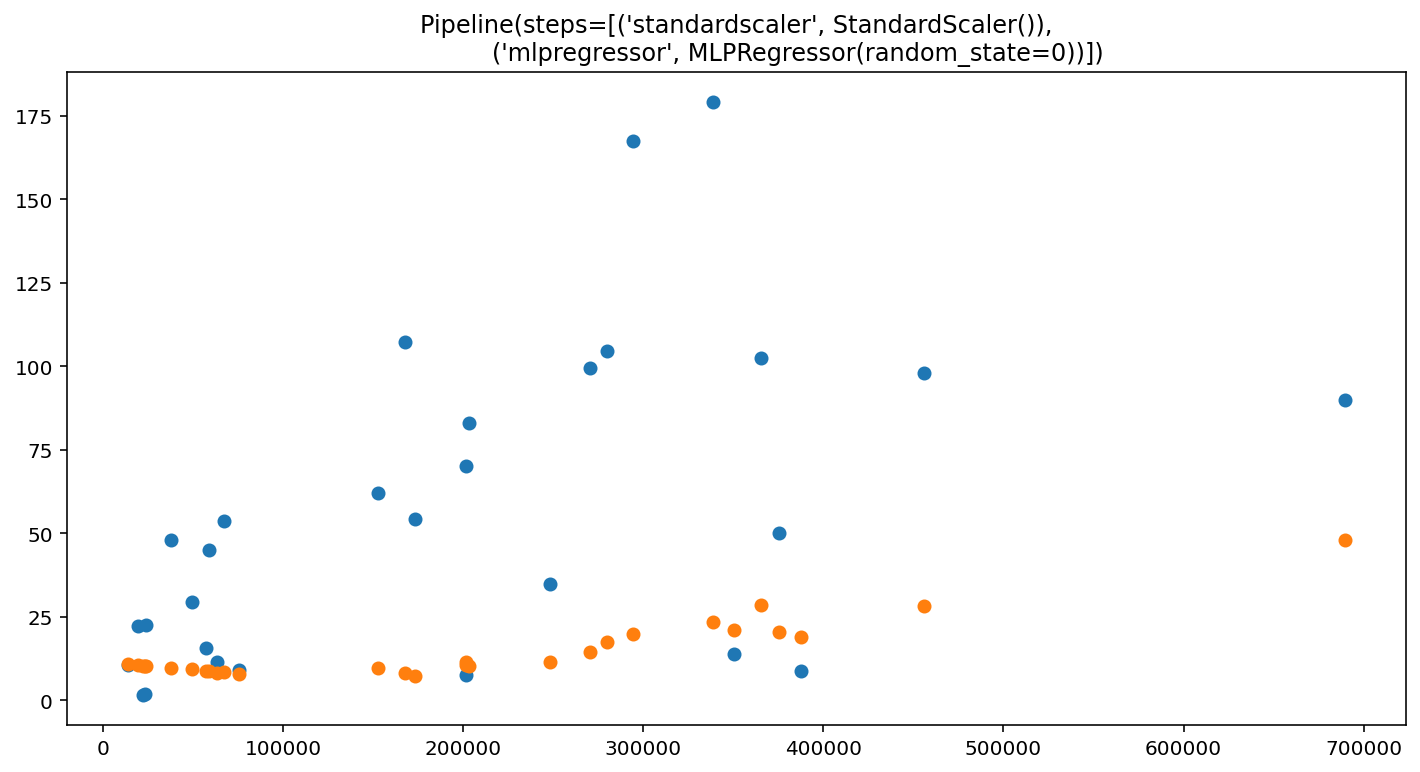

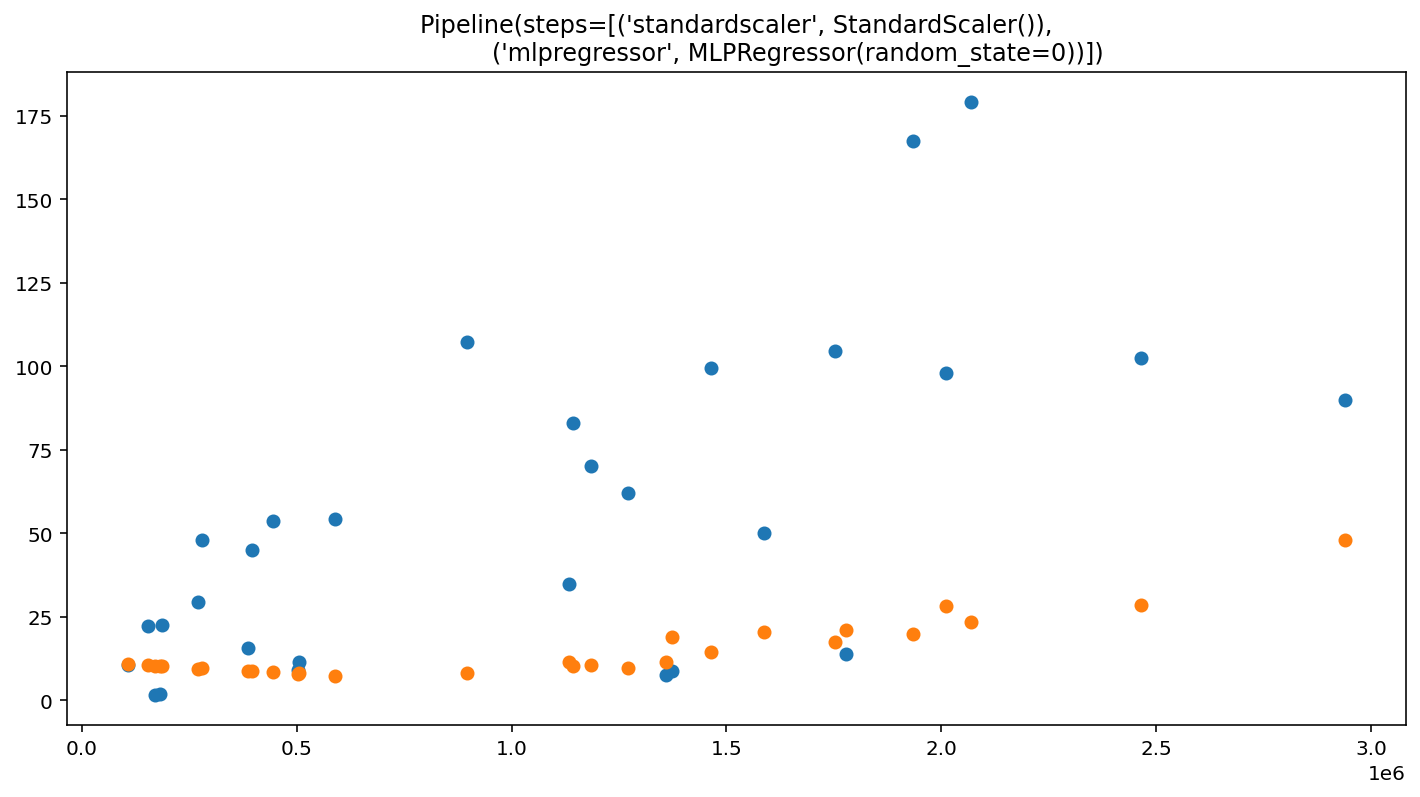

svm time_mean wifi_cloud 0
(63127, 11.615786885245903, 40.29896970079777)
(375327, 50.09792857142856, 62.08951446247012)
(13857, 10.724245283018869, 16.70913169795947)
(203013, 83.03524999999999, 63.47145017582026)
(280099, 104.6172857142857, 98.97081773641564)
(365615, 102.493, 141.5617240681501)
(49295, 29.405359999999995, 22.812821931282606)
(338821, 179.14320000000004, 113.00494471607908)
(201769, 7.765894736842105, 82.8357364278957)
(270445, 99.4935, 75.85605334058192)
(201689, 70.3048, 67.40047256219131)
(455703, 97.92974999999998, 80.56878636092699)
(294518, 167.56820000000002, 111.52585029004582)
(37953, 48.0266, 26.28088269652617)
(23433, 1.8867235294117644, 21.024358835326993)
(67133, 53.69654545454545, 34.00383689145639)
(57265, 15.698347826086955, 31.1180099786829)
(59127, 45.10023529411765, 31.548108798517617)
(75819, 9.256374999999998, 37.10711399928577)
(24177, 22.55975, 21.28499111600395)
(152703, 62.1933076923077, 86.64857032481592)
(248143, 34.80464285714286, 52.00971

In [108]:
where = 'wifi_cloud'
what = 'time_mean'
regr = 'svm'

curr = data[data['where'] == where].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(
            curr[['metric', 'file_size']].to_numpy(),
            curr[what].to_numpy(),
            test_size=0.3,
            random_state=0
        )
# plot_datasets(
#     models[where][what][regr][0],
#     X_train, y_train, X_test, y_test,
#     0,
#     True
# )


plot_datasets(
    models[where][what]['nn'][0],
    X_train, y_train, X_test, y_test,
    0,
    True
)

# plot_datasets(
#     models[where][what][regr][0],
#     X_train, y_train, X_test, y_test,
#     1,
#     True
# )


plot_datasets(
    models[where][what]['nn'][0],
    X_train, y_train, X_test, y_test,
    1,
    True
)

dim = 0
print('svm', what, where, dim)
print(*list(zip(X_test[:,dim], y_test, models[where][what]['svm'][0].predict(X_test))), sep='\n')

print('\n','nn', what, where, dim)
print(*list(zip(X_test[:,dim], y_test, models[where][what]['nn'][0].predict(X_test))), sep='\n')

print()
dim = 1
print('svm', what, where, dim)
print(*list(zip(X_test[:,dim], y_test, models[where][what]['svm'][0].predict(X_test))), sep='\n')

print('\n','nn', what, where, dim)
print(*list(zip(X_test[:,dim], y_test, models[where][what]['nn'][0].predict(X_test))), sep='\n')

In [ ]:
X_train[:,dim], pr.predict(X_train)

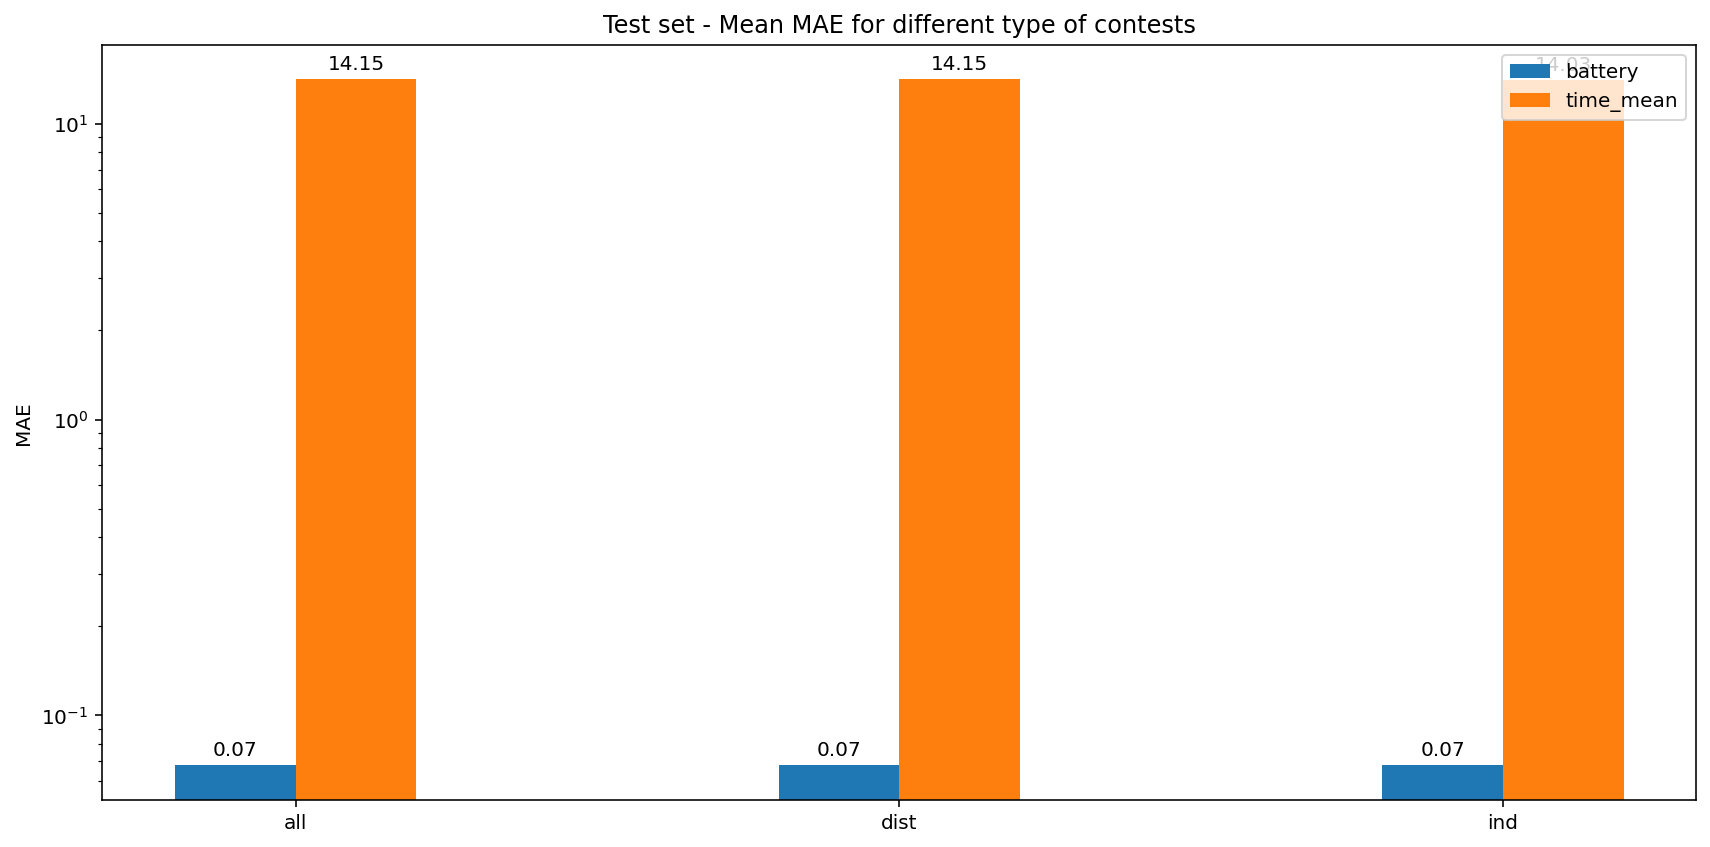

In [14]:
all_res
distinct_res
individ_res

labels = ['all', 'dist', 'ind']
batt_means = [
    abs(np.mean(all_res['battery'])),
    abs(np.mean(distinct_res['battery'])),
    abs(np.mean(individ_res['battery'])),
]

time_means = [
    abs(np.mean(all_res['time_mean'])),
    abs(np.mean(distinct_res['time_mean'])),
    abs(np.mean(individ_res['time_mean'])),
]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
ax.set_yscale('log')
rects1 = ax.bar(x - width/2, batt_means, width, label='battery')
rects2 = ax.bar(x + width/2, time_means, width, label='time_mean')

ax.set_ylabel('MAE')
ax.set_title('Test set - Mean MAE for different type of contests')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


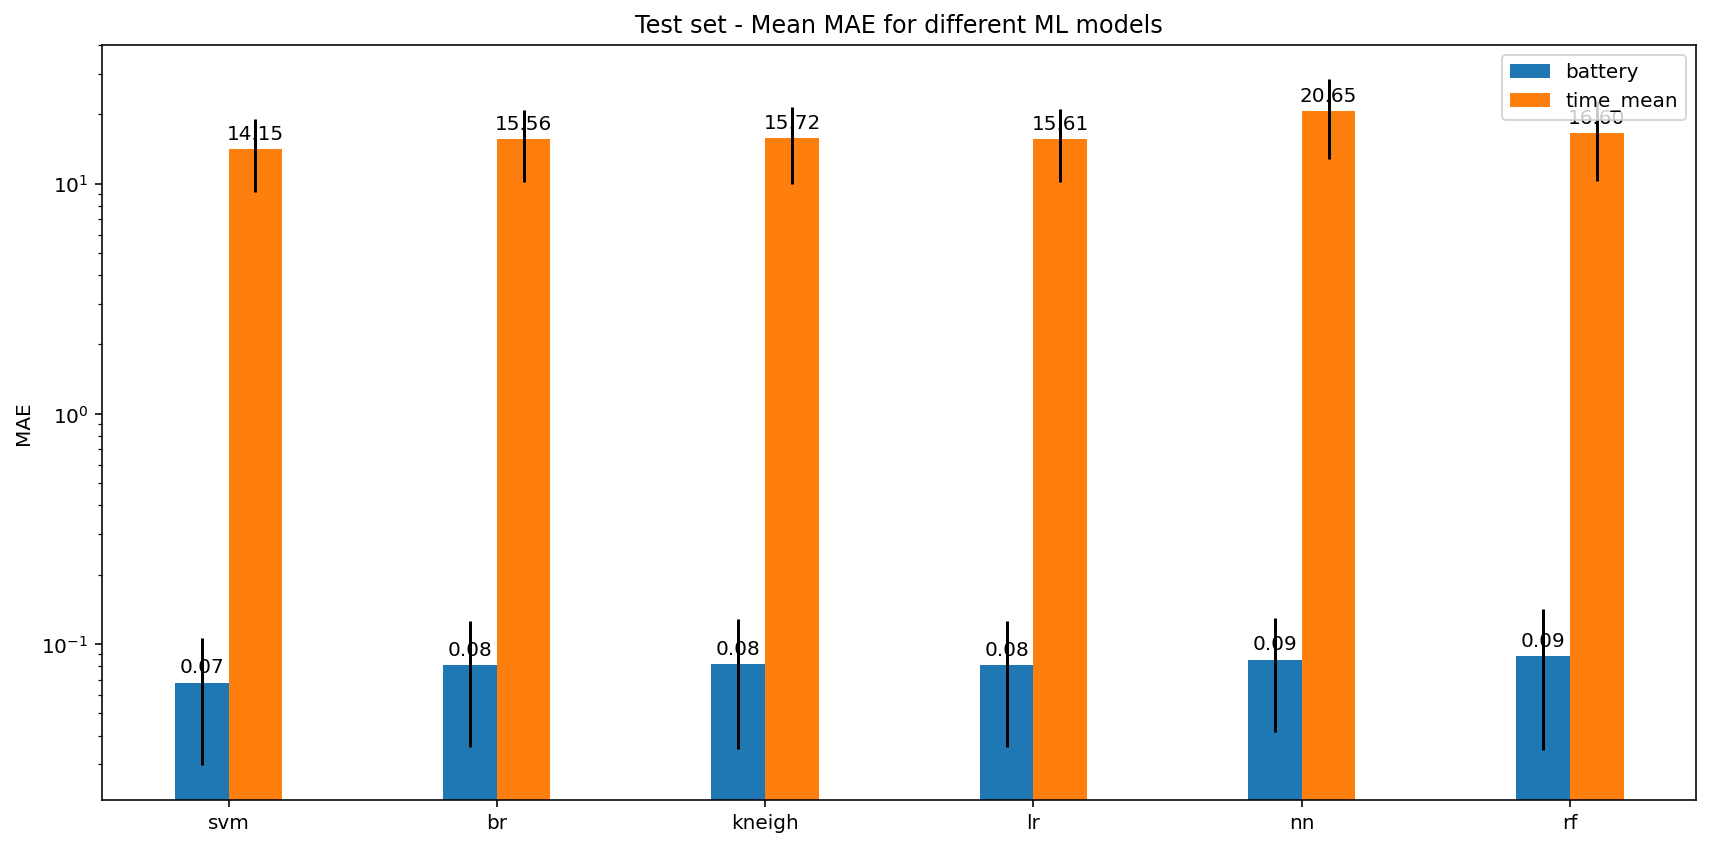

('svm', -14.14751873486058, 4.988123642986294)
('br', -15.557917962270801, 5.409032588825438)
('kneigh', -15.718192532030352, 5.748962478372151)
('lr', -15.605618304817465, 5.4327012460902475)
('nn', -20.64967214684413, 7.802816216863361)
('rf', -16.601369220823468, 6.346776432771927)

('svm', -0.06780255034704336, 0.03810515179198179)
('br', -0.08082272830441589, 0.04527270377586038)
('kneigh', -0.08166081587476468, 0.04655991403561082)
('lr', -0.0808227659541563, 0.04527273568000675)
('nn', -0.08540353287883633, 0.043939204833191775)
('rf', -0.08853039661092577, 0.05401290887379328)


In [63]:
# MAPE - general winners 

res = {
    'battery': [],
    'time_mean': []
}

for ct in contest_all:
    for what in ['battery', 'time_mean']:
        mn = []
        for where in where_combined:
            t = {k: [v[1], v[2]] for k, v in models[where][what].items()}
            mn.append(t[ct[0]][1])
        res[what].append((ct[0], np.mean(mn), np.std(mn)/2))
        
        
        


lables, y_battery, bat_std = list(zip(*res['battery']))
labels, y_timemean, time_std= list(zip(*res['time_mean']))

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
ax.set_yscale('log')
rects1 = ax.bar(x - width/2, np.abs(y_battery), width, label='battery', yerr=bat_std)
rects2 = ax.bar(x + width/2, np.abs(y_timemean), width, label='time_mean', yerr=time_std)

ax.set_ylabel('MAE')
ax.set_title('Test set - Mean MAE for different ML models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
# plt.title('battery')
# plt.bar(x, np.abs(y))
# plt.show()


# plt.title('time_mean')
# plt.bar(x, np.abs(y))
# plt.show()
print(*res['time_mean'], sep='\n')
print()
print(*res['battery'], sep='\n')

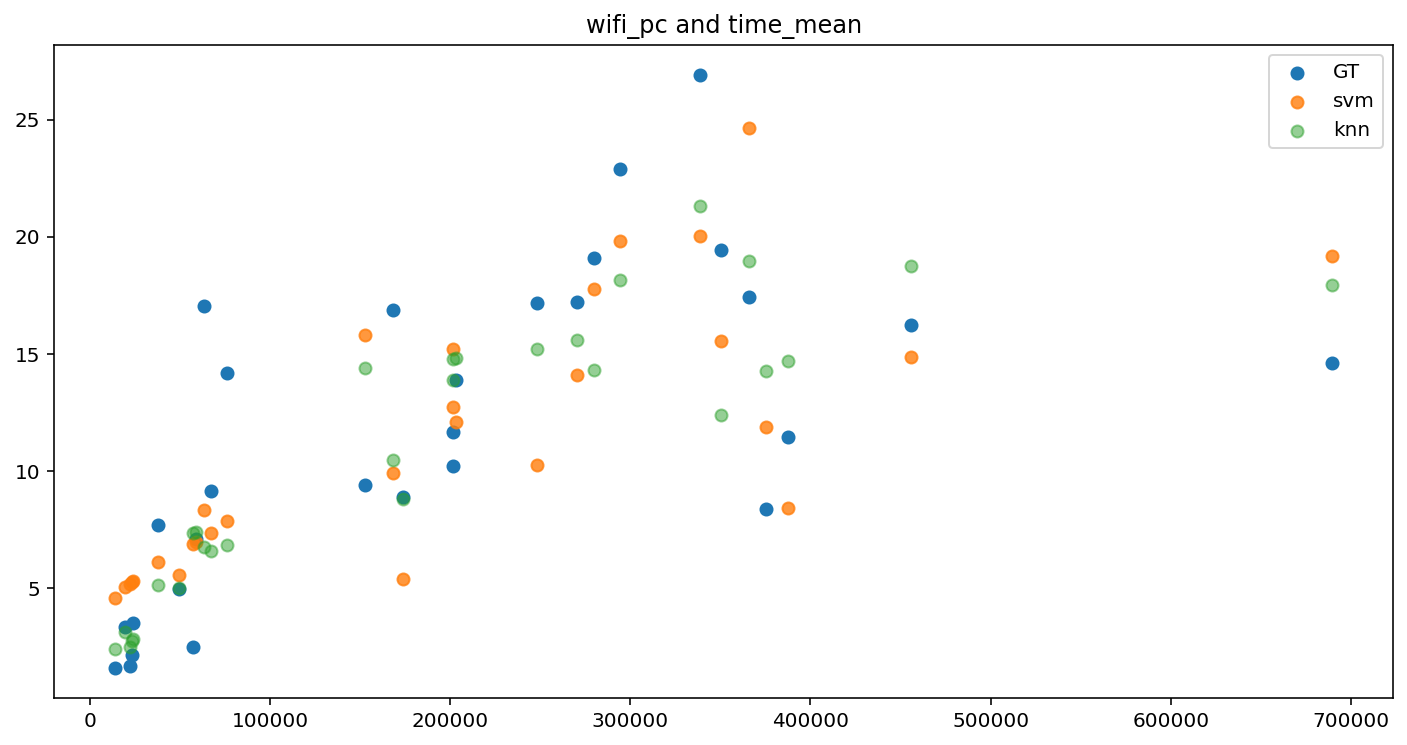

MAE svm:  -3.662785126206564
MAE knn:  -3.1891469325773754
The difference:  -0.47363819362918846


In [22]:
where = 'wifi_pc'
what = 'time_mean'

curr = data[data['where'] == where].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(
            curr[['metric', 'file_size']].to_numpy(),
            curr[what].to_numpy(),
            test_size=0.3,
            random_state=0
        )


plt.title(f'{where} and {what}')
plt.scatter(X_test[:,0], y_test)
plt.scatter(X_test[:,0], models[where][what]['svm'][0].predict(X_test), alpha=0.8)
plt.scatter(X_test[:,0], models[where][what]['kneigh'][0].predict(X_test), alpha=0.5)
# plt.scatter(X_test[:,0], prpr[0].predict(X_test), alpha=0.2)
plt.legend(['GT', 'svm', 'knn'])
plt.show()
print('MAE svm: ', models[where][what]['svm'][2])
print('MAE knn: ', models[where][what]['kneigh'][2])
print('The difference: ', models[where][what]['svm'][2] - models[where][what]['kneigh'][2])


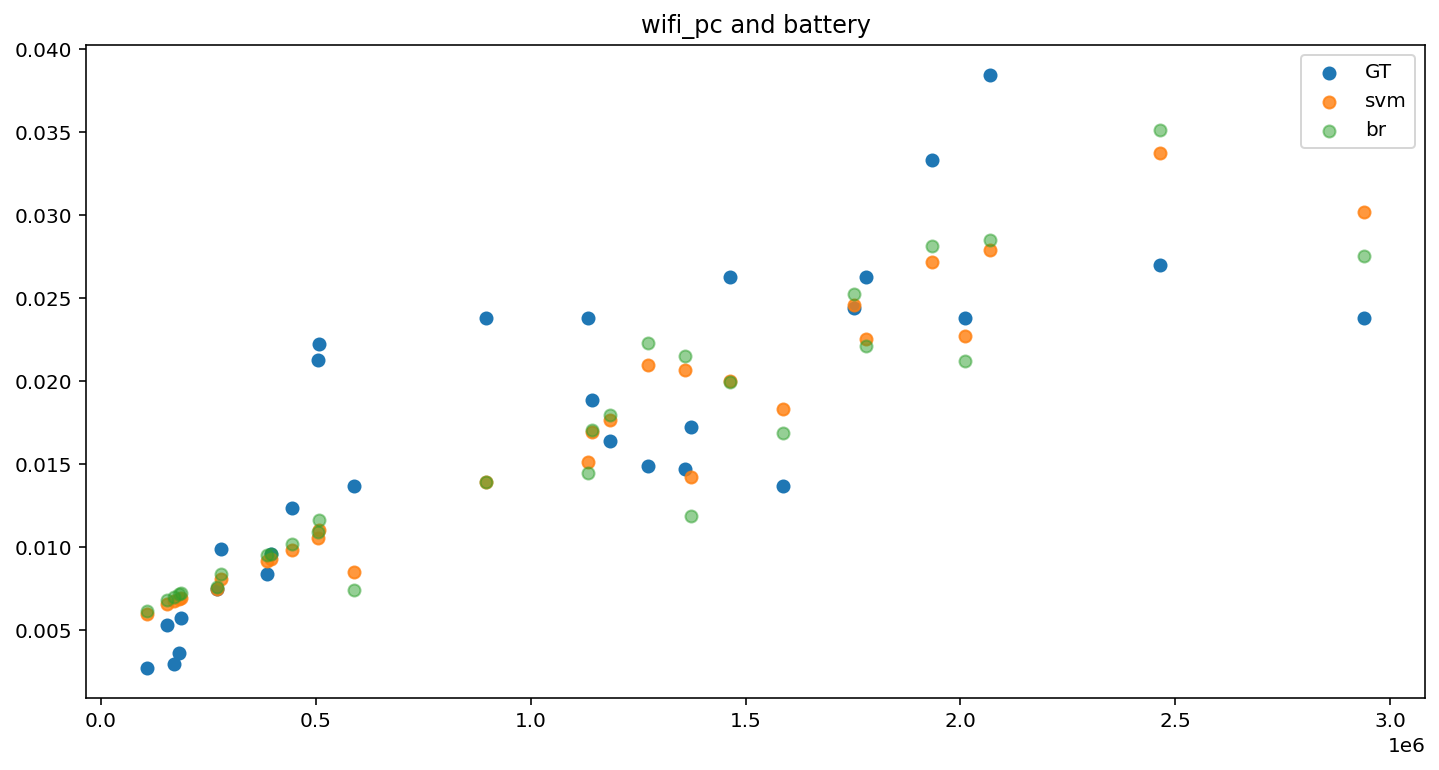

MAE svm:  -0.004415585938272324
MAE br:  -0.004568838258746001
The difference:  0.00015325232047367666


In [23]:
where = 'wifi_pc'
what = 'battery'

curr = data[data['where'] == where].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(
            curr[['metric', 'file_size']].to_numpy(),
            curr[what].to_numpy(),
            test_size=0.3,
            random_state=0
        )


plt.title(f'{where} and {what}')
plt.scatter(X_test[:,1], y_test)
plt.scatter(X_test[:,1], models[where][what]['svm'][0].predict(X_test), alpha=0.8)
plt.scatter(X_test[:,1], models[where][what]['br'][0].predict(X_test), alpha=0.5)
# plt.scatter(X_test[:,0], prpr[0].predict(X_test), alpha=0.2)
plt.legend(['GT', 'svm', 'br'])
plt.show()
print('MAE svm: ', models[where][what]['svm'][2])
print('MAE br: ', models[where][what]['br'][2])
print('The difference: ', models[where][what]['svm'][2] - models[where][what]['br'][2])

In [34]:
for what in ['battery', 'time_mean']:    
    for where in where_combined:
        joblib.dump(models[where][what][contest_all[0][0]][0], f'models/{what}-{where}.joblib')
        parameters = {name.split('__')[1]: value for name, value in models[where][what][contest_all[0][0]][0].best_params_.items()}
        print(what, where, '\t', parameters)

battery none_mobile 	 {'C': 1, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}
battery wifi_pc 	 {'C': 1, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}
battery wifi_cloud 	 {'C': 500, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}
battery cellular_cloud 	 {'C': 0.1, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}
time_mean none_mobile 	 {'C': 50, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}
time_mean wifi_pc 	 {'C': 10, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}
time_mean wifi_cloud 	 {'C': 200, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}
time_mean cellular_cloud 	 {'C': 20, 'epsilon': 0.0001, 'kernel': 'linear', 'tol': 0.001}


In [35]:
X_test

array([[  63127,  506177],
       [ 375327, 1586864],
       [  13857,  106640],
       [ 203013, 1142769],
       [ 280099, 1751865],
       [ 365615, 2464041],
       [  49295,  270562],
       [ 338821, 2068036],
       [ 201769, 1359498],
       [ 270445, 1463437],
       [ 201689, 1183884],
       [ 455703, 2011329],
       [ 294518, 1933011],
       [  37953,  279707],
       [  23433,  181229],
       [  67133,  445331],
       [  57265,  386206],
       [  59127,  396062],
       [  75819,  503773],
       [  24177,  186176],
       [ 152703, 1271899],
       [ 248143, 1132946],
       [  19603,  154347],
       [ 387471, 1372006],
       [ 168003,  895632],
       [ 173551,  588780],
       [  22371,  170870],
       [ 689709, 2939906],
       [ 350231, 1779213]])